# LSTM向けEDA分析

このノートブックでは、LSTM時系列モデルの開発に向けて、以下の観点でEDAを実施します：

1. **時系列パターンの可視化**
2. **シーケンス長分布の確認**
3. **センサー間の時系列相関**
4. **ウィンドウ分割戦略の検討**
5. **時系列特徴量の抽出可能性**
6. **FFT/周波数解析**


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.fft import fft, fftfreq
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

# 日本語フォント設定
plt.rcParams['font.family'] = 'DejaVu Sans'
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("ライブラリ読み込み完了")


ライブラリ読み込み完了


## 1. データ読み込み


In [36]:
# データパス設定（CSVファイル）
DATA_PATH = '../data/'

# 学習データ読み込み
print("学習データ読み込み中...")
train_df = pd.read_csv(f'{DATA_PATH}train.csv')
print(f"学習データ形状: {train_df.shape}")
print(f"列名数: {len(train_df.columns)}")
print(f"ユニークなジェスチャー数: {train_df['gesture'].nunique()}")
print(f"ユニークなsequence_id数: {train_df['sequence_id'].nunique()}")
print(f"データ読み込み完了")


学習データ読み込み中...
学習データ形状: (574945, 341)
列名数: 341
ユニークなジェスチャー数: 18
ユニークなsequence_id数: 8151
データ読み込み完了


In [37]:
# データ構造の確認
print("データ構造確認:")
print(train_df.head())
print("\n列名一覧:")
print(train_df.columns.tolist())

# センサー列の特定
sensor_cols = [col for col in train_df.columns if any(sensor in col for sensor in ['acc_', 'rot_', 'tof_', 'thm_'])]
print(f"\nセンサー列数: {len(sensor_cols)}")
print(f"センサー列の例: {sensor_cols[:10]}")  # 最初の10個のみ表示

# ジェスチャー分布確認
gesture_counts = train_df['gesture'].value_counts()
print(f"\nジェスチャー分布:")
print(gesture_counts)


データ構造確認:
              row_id sequence_type sequence_id  sequence_counter      subject  \
0  SEQ_000007_000000        Target  SEQ_000007                 0  SUBJ_059520   
1  SEQ_000007_000001        Target  SEQ_000007                 1  SUBJ_059520   
2  SEQ_000007_000002        Target  SEQ_000007                 2  SUBJ_059520   
3  SEQ_000007_000003        Target  SEQ_000007                 3  SUBJ_059520   
4  SEQ_000007_000004        Target  SEQ_000007                 4  SUBJ_059520   

                       orientation                                   behavior  \
0  Seated Lean Non Dom - FACE DOWN  Relaxes and moves hand to target location   
1  Seated Lean Non Dom - FACE DOWN  Relaxes and moves hand to target location   
2  Seated Lean Non Dom - FACE DOWN  Relaxes and moves hand to target location   
3  Seated Lean Non Dom - FACE DOWN  Relaxes and moves hand to target location   
4  Seated Lean Non Dom - FACE DOWN  Relaxes and moves hand to target location   

        phase    

## 2. シーケンス長分布の分析


シーケンス長統計:
count    8151.000000
mean       70.536744
std        35.389879
min        29.000000
25%        51.000000
50%        59.000000
75%        78.000000
max       700.000000
dtype: float64


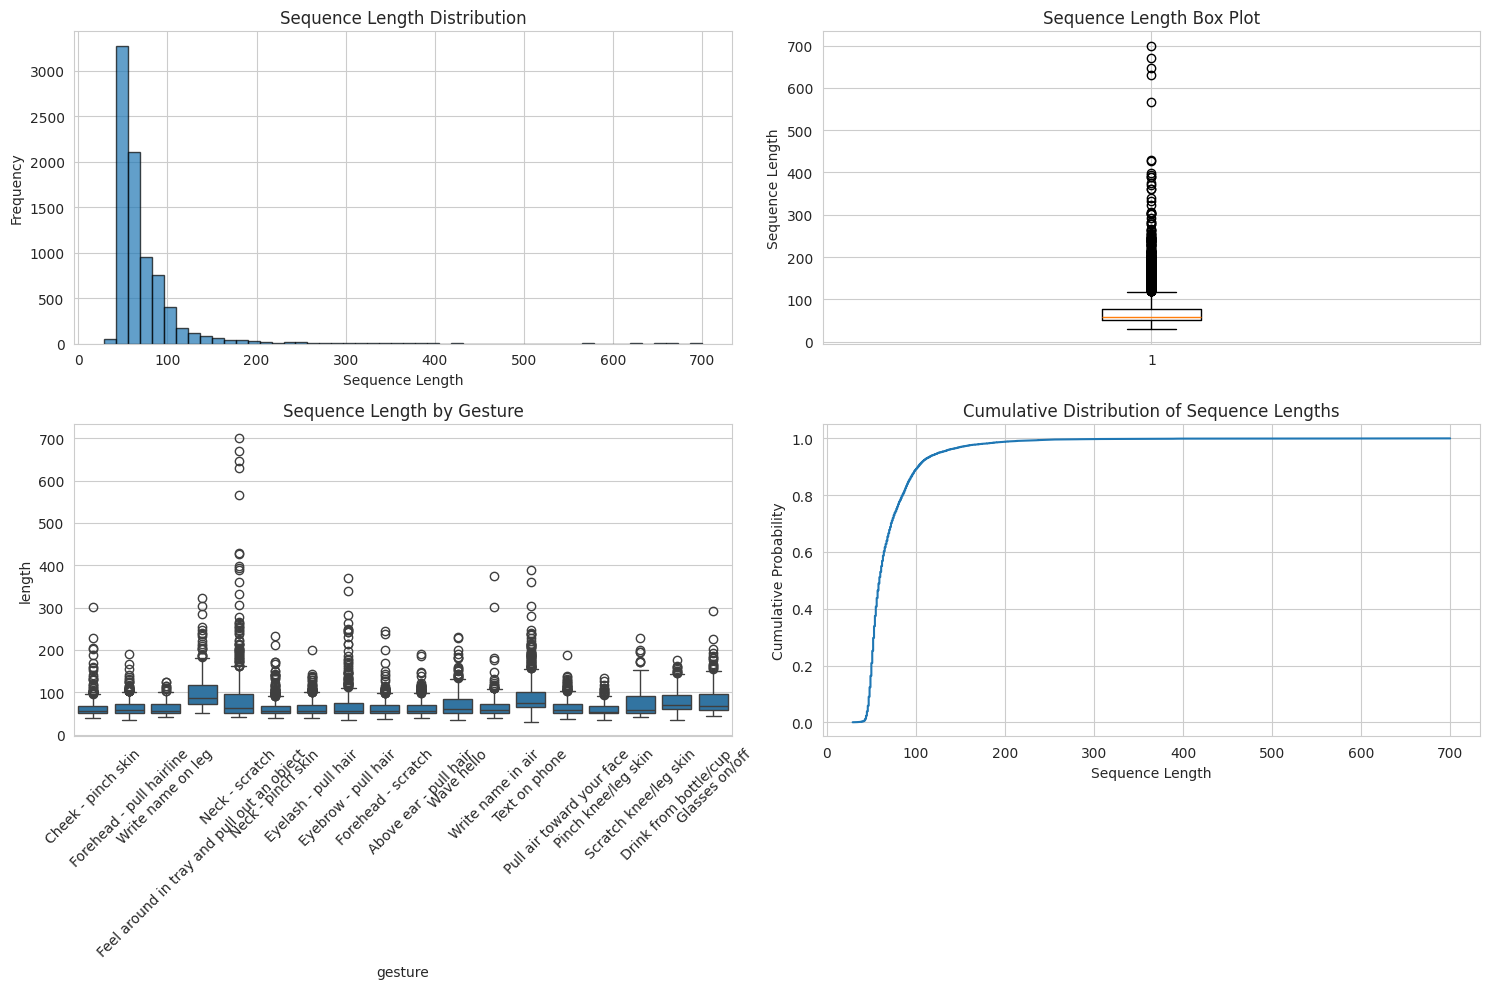


ウィンドウサイズ検討:
Window Size 32: 8150/8151 sequences (100.0%)
Window Size 64: 3369/8151 sequences (41.3%)
Window Size 128: 400/8151 sequences (4.9%)
Window Size 256: 33/8151 sequences (0.4%)
Window Size 512: 5/8151 sequences (0.1%)


In [38]:
# シーケンス長の計算
sequence_lengths = train_df.groupby('sequence_id').size()
print(f"シーケンス長統計:")
print(sequence_lengths.describe())

# シーケンス長分布の可視化
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# ヒストグラム
axes[0,0].hist(sequence_lengths, bins=50, alpha=0.7, edgecolor='black')
axes[0,0].set_title('Sequence Length Distribution')
axes[0,0].set_xlabel('Sequence Length')
axes[0,0].set_ylabel('Frequency')

# ボックスプロット
axes[0,1].boxplot(sequence_lengths)
axes[0,1].set_title('Sequence Length Box Plot')
axes[0,1].set_ylabel('Sequence Length')

# ジェスチャー別シーケンス長
gesture_seq_lengths = train_df.groupby(['sequence_id', 'gesture']).size().reset_index()
gesture_seq_lengths.columns = ['sequence_id', 'gesture', 'length']
sns.boxplot(data=gesture_seq_lengths, x='gesture', y='length', ax=axes[1,0])
axes[1,0].set_title('Sequence Length by Gesture')
axes[1,0].tick_params(axis='x', rotation=45)

# 累積分布
sorted_lengths = np.sort(sequence_lengths)
cumulative = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths)
axes[1,1].plot(sorted_lengths, cumulative)
axes[1,1].set_title('Cumulative Distribution of Sequence Lengths')
axes[1,1].set_xlabel('Sequence Length')
axes[1,1].set_ylabel('Cumulative Probability')
axes[1,1].grid(True)

plt.tight_layout()
plt.show()

# ウィンドウサイズ検討用の統計
print(f"\nウィンドウサイズ検討:")
for window_size in [32, 64, 128, 256, 512]:
    valid_sequences = (sequence_lengths >= window_size).sum()
    coverage = valid_sequences / len(sequence_lengths) * 100
    print(f"Window Size {window_size}: {valid_sequences}/{len(sequence_lengths)} sequences ({coverage:.1f}%)")


In [39]:
def simulate_windowing(sequence_length, window_size, stride):
    """ウィンドウ分割のシミュレーション"""
    if sequence_length < window_size:
        return 0
    
    num_windows = (sequence_length - window_size) // stride + 1
    return num_windows

# 異なるウィンドウサイズとストライドでのシミュレーション
window_configs = [
    (64, 16), (64, 32), (64, 48),
    (128, 32), (128, 64), (128, 96),
    (256, 64), (256, 128), (256, 192)
]

simulation_results = []

for window_size, stride in window_configs:
    total_windows = 0
    valid_sequences = 0
    
    for seq_len in sequence_lengths:
        num_windows = simulate_windowing(seq_len, window_size, stride)
        if num_windows > 0:
            total_windows += num_windows
            valid_sequences += 1
    
    coverage = valid_sequences / len(sequence_lengths) * 100
    avg_windows_per_seq = total_windows / valid_sequences if valid_sequences > 0 else 0
    
    simulation_results.append({
        'window_size': window_size,
        'stride': stride,
        'total_windows': total_windows,
        'valid_sequences': valid_sequences,
        'coverage_pct': coverage,
        'avg_windows_per_seq': avg_windows_per_seq
    })

sim_df = pd.DataFrame(simulation_results)
print("ウィンドウ分割シミュレーション結果:")
print(sim_df.round(2))


ウィンドウ分割シミュレーション結果:
   window_size  stride  total_windows  valid_sequences  coverage_pct  \
0           64      16           8611             3369         41.33   
1           64      32           5365             3369         41.33   
2           64      48           4344             3369         41.33   
3          128      32            922              400          4.91   
4          128      64            592              400          4.91   
5          128      96            499              400          4.91   
6          256      64             79               33          0.40   
7          256     128             52               33          0.40   
8          256     192             41               33          0.40   

   avg_windows_per_seq  
0                 2.56  
1                 1.59  
2                 1.29  
3                 2.31  
4                 1.48  
5                 1.25  
6                 2.39  
7                 1.58  
8                 1.24  


## 3. 時系列パターンの可視化


In [40]:
# 各ジェスチャーからサンプルを選択して時系列パターンを可視化
sample_sequences = []
unique_gestures = train_df['gesture'].unique()

for gesture in unique_gestures:
    gesture_seqs = train_df[train_df['gesture'] == gesture]['sequence_id'].unique()
    # 中程度の長さのシーケンスを選択
    seq_lengths = {}
    for seq in gesture_seqs:
        seq_lengths[seq] = len(train_df[train_df['sequence_id'] == seq])
    
    median_length = np.median(list(seq_lengths.values()))
    best_seq = min(seq_lengths.keys(), key=lambda x: abs(seq_lengths[x] - median_length))
    sample_sequences.append((gesture, best_seq))

print(f"サンプルシーケンス選択完了: {len(sample_sequences)}個")
print("選択されたシーケンス:")
for gesture, seq_id in sample_sequences:
    seq_len = len(train_df[train_df['sequence_id'] == seq_id])
    print(f"  {gesture}: {seq_id} (長さ: {seq_len})")


サンプルシーケンス選択完了: 18個
選択されたシーケンス:
  Cheek - pinch skin: SEQ_006745 (長さ: 55)
  Forehead - pull hairline: SEQ_002324 (長さ: 57)
  Write name on leg: SEQ_013107 (長さ: 56)
  Feel around in tray and pull out an object: SEQ_000239 (長さ: 86)
  Neck - scratch: SEQ_018166 (長さ: 62)
  Neck - pinch skin: SEQ_000765 (長さ: 56)
  Eyelash - pull hair: SEQ_005194 (長さ: 56)
  Eyebrow - pull hair: SEQ_000492 (長さ: 56)
  Forehead - scratch: SEQ_002363 (長さ: 56)
  Above ear - pull hair: SEQ_000949 (長さ: 56)
  Wave hello: SEQ_006414 (長さ: 60)
  Write name in air: SEQ_001375 (長さ: 57)
  Text on phone: SEQ_005518 (長さ: 75)
  Pull air toward your face: SEQ_002876 (長さ: 58)
  Pinch knee/leg skin: SEQ_000259 (長さ: 54)
  Scratch knee/leg skin: SEQ_015078 (長さ: 58)
  Drink from bottle/cup: SEQ_013365 (長さ: 69)
  Glasses on/off: SEQ_010756 (長さ: 68)


In [41]:
def simulate_windowing(sequence_length, window_size, stride):
    """ウィンドウ分割のシミュレーション"""
    if sequence_length < window_size:
        return 0
    
    num_windows = (sequence_length - window_size) // stride + 1
    return num_windows

# 異なるウィンドウサイズとストライドでのシミュレーション
window_configs = [
    (64, 16), (64, 32), (64, 48),
    (128, 32), (128, 64), (128, 96),
    (256, 64), (256, 128), (256, 192)
]

simulation_results = []

for window_size, stride in window_configs:
    total_windows = 0
    valid_sequences = 0
    
    for seq_len in sequence_lengths:
        num_windows = simulate_windowing(seq_len, window_size, stride)
        if num_windows > 0:
            total_windows += num_windows
            valid_sequences += 1
    
    coverage = valid_sequences / len(sequence_lengths) * 100
    avg_windows_per_seq = total_windows / valid_sequences if valid_sequences > 0 else 0
    
    simulation_results.append({
        'window_size': window_size,
        'stride': stride,
        'total_windows': total_windows,
        'valid_sequences': valid_sequences,
        'coverage_pct': coverage,
        'avg_windows_per_seq': avg_windows_per_seq
    })

sim_df = pd.DataFrame(simulation_results)
print("ウィンドウ分割シミュレーション結果:")
print(sim_df.round(2))


ウィンドウ分割シミュレーション結果:
   window_size  stride  total_windows  valid_sequences  coverage_pct  \
0           64      16           8611             3369         41.33   
1           64      32           5365             3369         41.33   
2           64      48           4344             3369         41.33   
3          128      32            922              400          4.91   
4          128      64            592              400          4.91   
5          128      96            499              400          4.91   
6          256      64             79               33          0.40   
7          256     128             52               33          0.40   
8          256     192             41               33          0.40   

   avg_windows_per_seq  
0                 2.56  
1                 1.59  
2                 1.29  
3                 2.31  
4                 1.48  
5                 1.25  
6                 2.39  
7                 1.58  
8                 1.24  


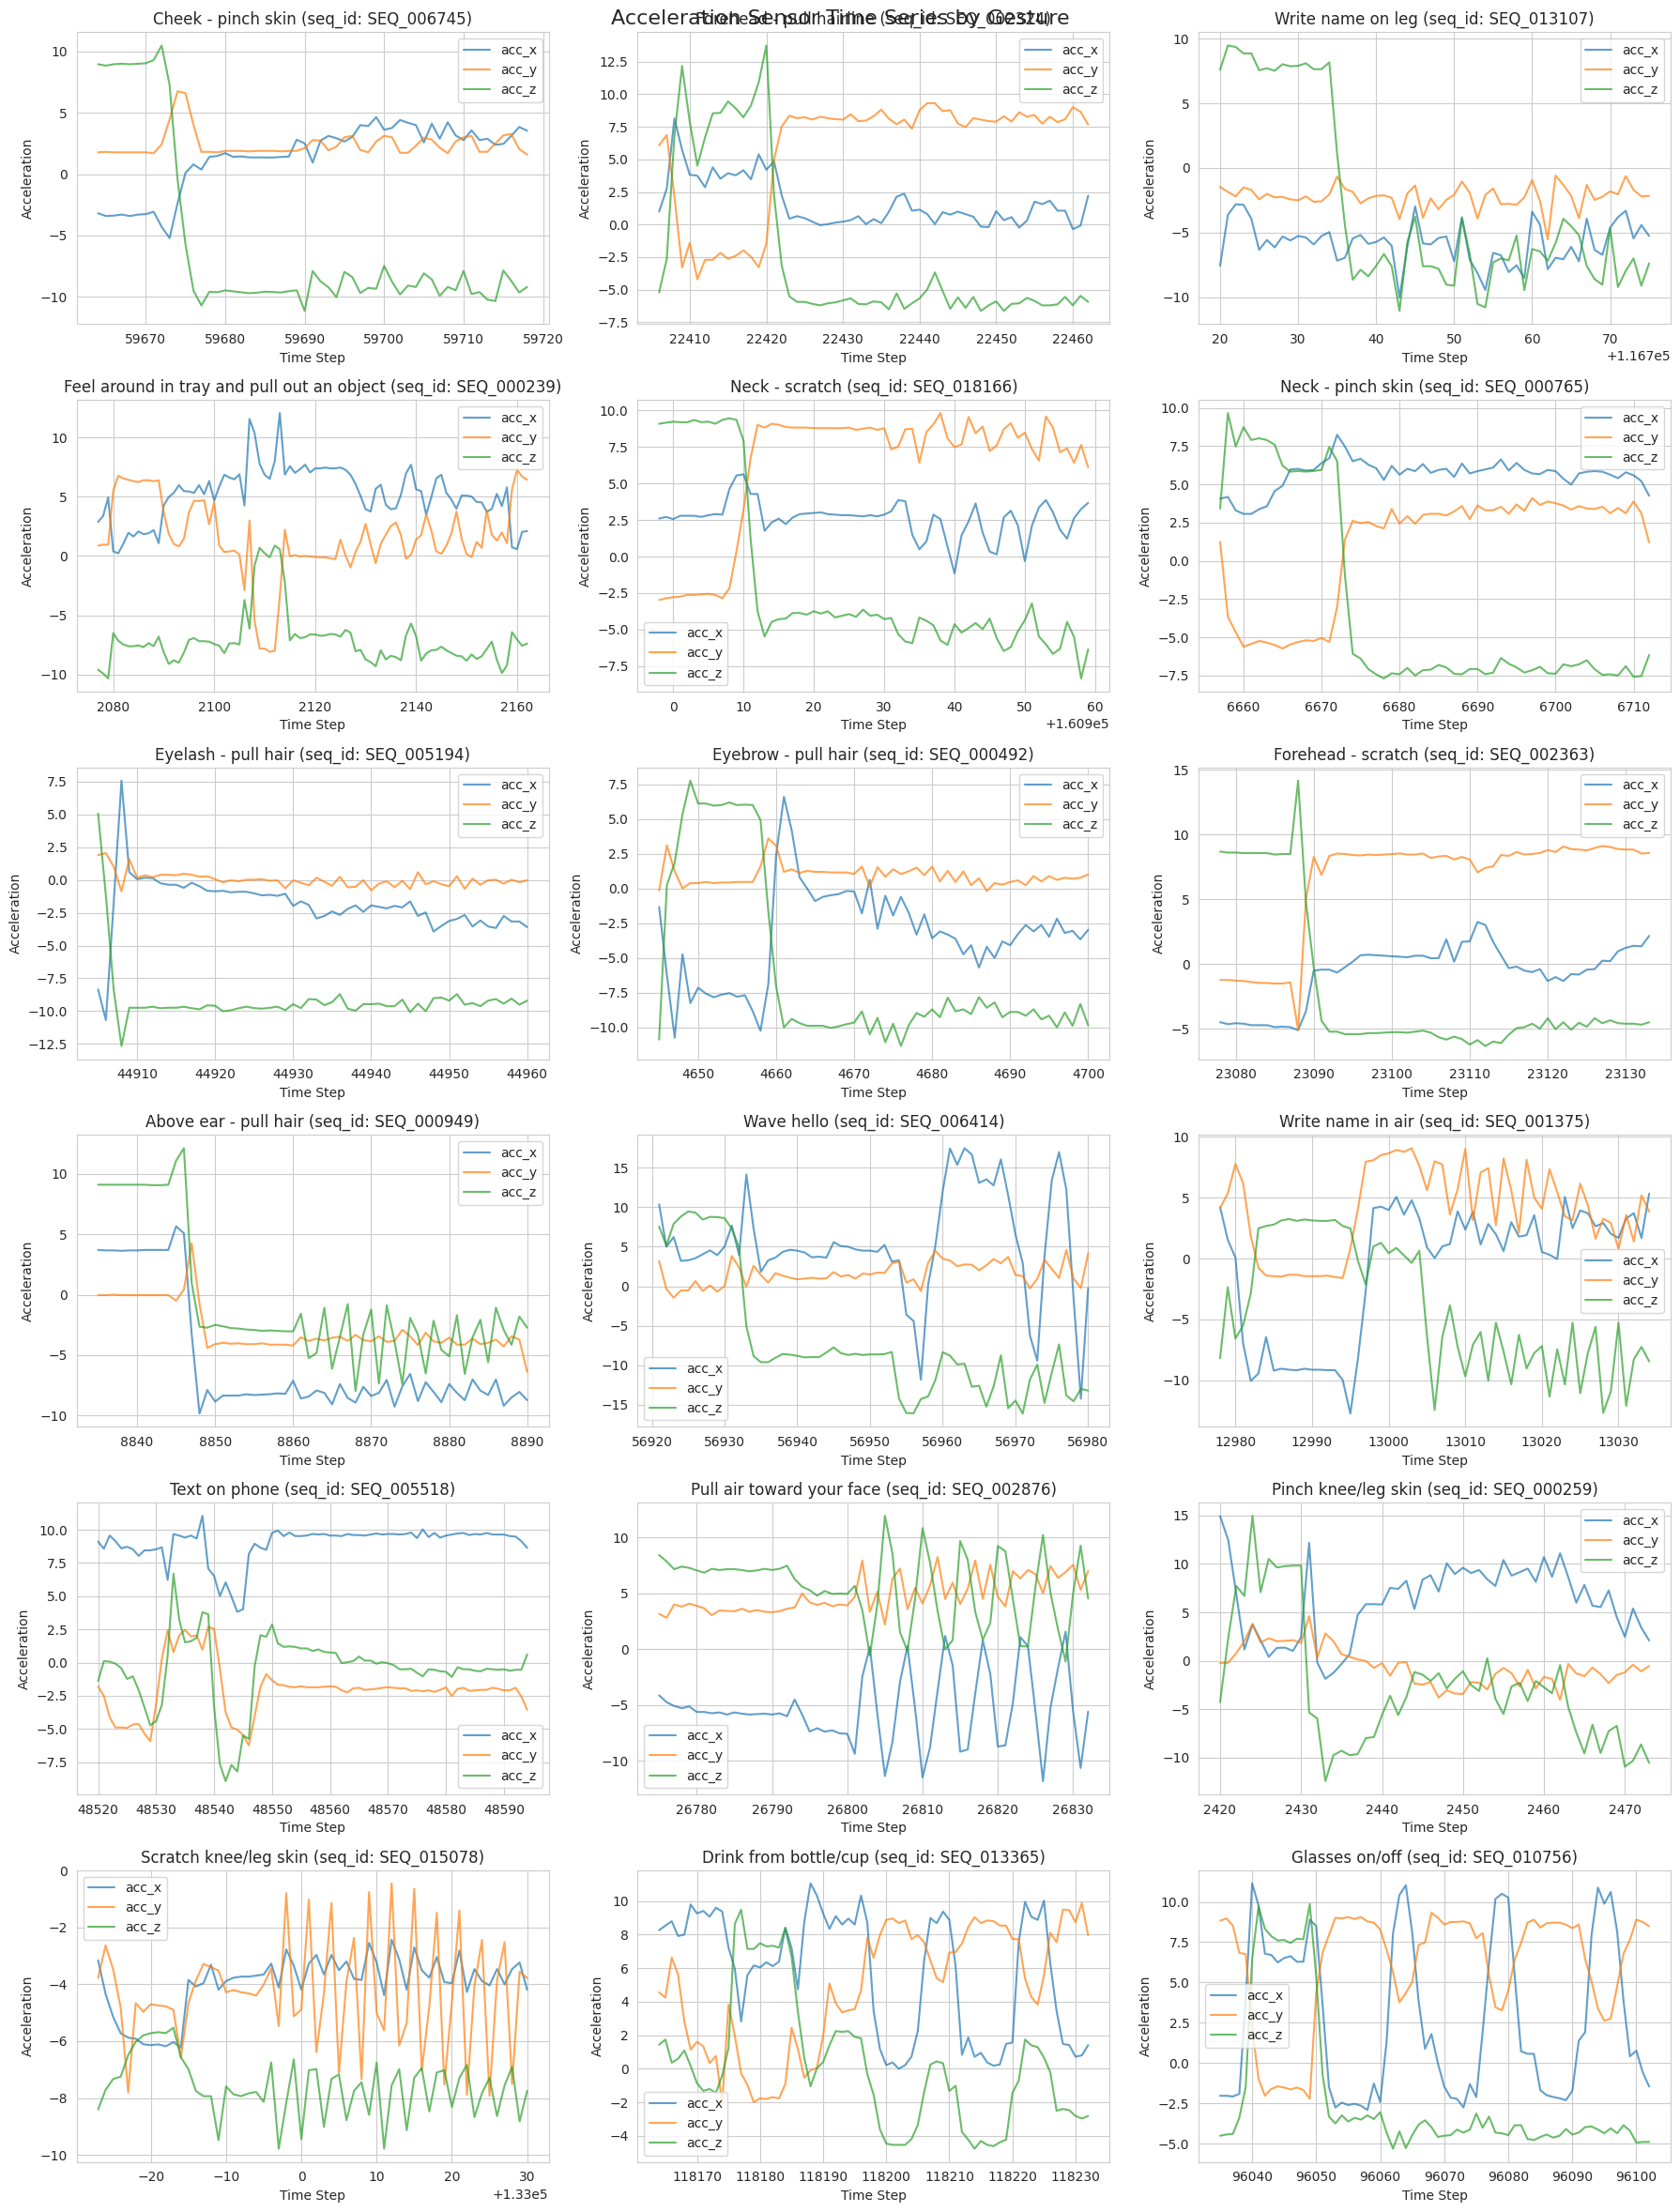

In [42]:
# 加速度センサーの時系列パターン可視化
acc_cols = [col for col in sensor_cols if 'acc_' in col]
n_gestures = len(sample_sequences)
n_cols = 3
n_rows = (n_gestures + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4*n_rows))
if n_rows == 1:
    axes = [axes] if n_cols == 1 else axes
else:
    axes = axes.flatten()

for i, (gesture, seq_id) in enumerate(sample_sequences):
    seq_data = train_df[train_df['sequence_id'] == seq_id].sort_values('sequence_counter')
    
    for col in acc_cols:
        if col in seq_data.columns:
            axes[i].plot(seq_data[col], label=col, alpha=0.7)
    
    axes[i].set_title(f'{gesture} (seq_id: {seq_id})')
    axes[i].set_xlabel('Time Step')
    axes[i].set_ylabel('Acceleration')
    axes[i].legend()
    axes[i].grid(True)

# 余った軸を非表示
for i in range(len(sample_sequences), len(axes)):
    axes[i].set_visible(False)

plt.suptitle('Acceleration Sensor Time Series by Gesture', fontsize=16)
plt.tight_layout()
plt.show()


## 4. 時系列特徴量の分析


In [43]:
def extract_time_series_features(series):
    """時系列データから特徴量を抽出"""
    features = {}
    
    # 基本統計量
    features['mean'] = series.mean()
    features['std'] = series.std()
    features['min'] = series.min()
    features['max'] = series.max()
    features['range'] = series.max() - series.min()
    
    # 変化率特徴
    diff = series.diff().dropna()
    features['diff_mean'] = diff.mean()
    features['diff_std'] = diff.std()
    
    # ピーク検出
    try:
        peaks, _ = signal.find_peaks(series, height=series.mean())
        features['num_peaks'] = len(peaks)
    except:
        features['num_peaks'] = 0
    
    # ゼロクロッシング
    try:
        zero_crossings = np.where(np.diff(np.sign(series - series.mean())))[0]
        features['zero_crossings'] = len(zero_crossings)
    except:
        features['zero_crossings'] = 0
    
    # エネルギー
    features['energy'] = np.sum(series ** 2)
    
    return features

# サンプルシーケンスの特徴量抽出
feature_analysis = []

for gesture, seq_id in sample_sequences:
    seq_data = train_df[train_df['sequence_id'] == seq_id].sort_values('sequence_counter')
    
    for col in acc_cols[:3]:  # 最初の3つの加速度センサーのみ
        if col in seq_data.columns:
            features = extract_time_series_features(seq_data[col])
            features['gesture'] = gesture
            features['sensor'] = col
            features['seq_id'] = seq_id
            feature_analysis.append(features)

if feature_analysis:
    feature_df = pd.DataFrame(feature_analysis)
    print(f"特徴量分析データ形状: {feature_df.shape}")
    print(feature_df.head())
else:
    print("特徴量抽出に失敗しました")


特徴量分析データ形状: (54, 13)
       mean       std        min        max      range  diff_mean  diff_std  \
0  1.389986  2.693229  -5.218750   4.652344   9.871094   0.124711  0.873582   
1  2.431676  1.045790   1.589844   6.761719   5.171875  -0.003472  0.801747   
2 -5.758310  7.173195 -11.164062  10.500000  21.664062  -0.336661  1.719759   
3  1.666118  1.841632  -0.355469   8.148438   8.503906   0.021833  1.222751   
4  5.720737  4.448693  -4.207031   9.316406  13.523438   0.028181  1.539095   

   num_peaks  zero_crossings       energy                   gesture sensor  \
0         12               5   497.951340        Cheek - pinch skin  acc_x   
1          7              14   384.276215        Cheek - pinch skin  acc_y   
2          2               1  4602.252335        Cheek - pinch skin  acc_z   
3          9               9   348.159302  Forehead - pull hairline  acc_x   
4         15               2  2973.718338  Forehead - pull hairline  acc_y   

       seq_id  
0  SEQ_006745  
1  

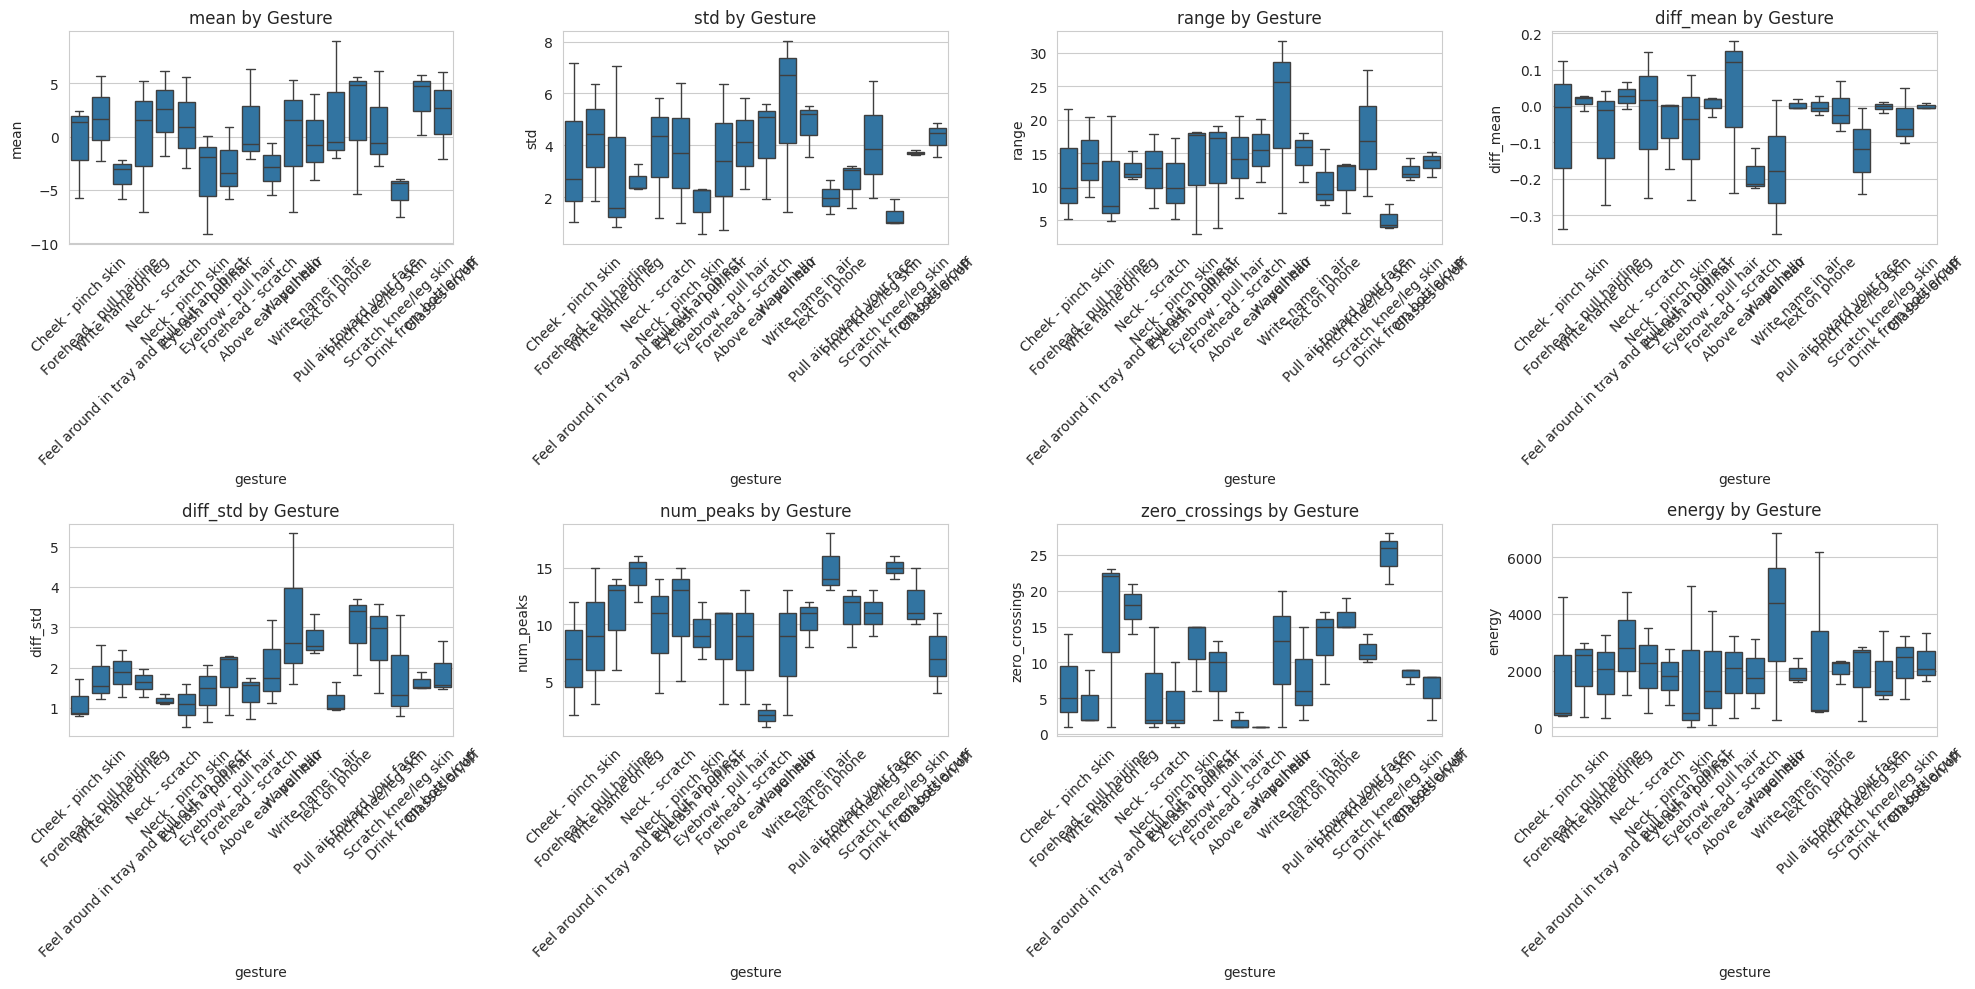

In [44]:
# 特徴量の可視化
if 'feature_df' in locals() and len(feature_df) > 0:
    numeric_features = ['mean', 'std', 'range', 'diff_mean', 'diff_std', 'num_peaks', 'zero_crossings', 'energy']
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    for i, feature in enumerate(numeric_features):
        if feature in feature_df.columns:
            sns.boxplot(data=feature_df, x='gesture', y=feature, ax=axes[i])
            axes[i].set_title(f'{feature} by Gesture')
            axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
else:
    print("特徴量データが利用できません")


## 5. ウィンドウ分割シミュレーション


In [45]:
def simulate_windowing(sequence_length, window_size, stride):
    """ウィンドウ分割のシミュレーション"""
    if sequence_length < window_size:
        return 0
    
    num_windows = (sequence_length - window_size) // stride + 1
    return num_windows

# 異なるウィンドウサイズとストライドでのシミュレーション
window_configs = [
    (64, 16), (64, 32), (64, 48),
    (128, 32), (128, 64), (128, 96),
    (256, 64), (256, 128), (256, 192)
]

simulation_results = []

for window_size, stride in window_configs:
    total_windows = 0
    valid_sequences = 0
    
    for seq_len in sequence_lengths:
        num_windows = simulate_windowing(seq_len, window_size, stride)
        if num_windows > 0:
            total_windows += num_windows
            valid_sequences += 1
    
    coverage = valid_sequences / len(sequence_lengths) * 100
    avg_windows_per_seq = total_windows / valid_sequences if valid_sequences > 0 else 0
    
    simulation_results.append({
        'window_size': window_size,
        'stride': stride,
        'total_windows': total_windows,
        'valid_sequences': valid_sequences,
        'coverage_pct': coverage,
        'avg_windows_per_seq': avg_windows_per_seq
    })

sim_df = pd.DataFrame(simulation_results)
print("ウィンドウ分割シミュレーション結果:")
print(sim_df.round(2))


ウィンドウ分割シミュレーション結果:
   window_size  stride  total_windows  valid_sequences  coverage_pct  \
0           64      16           8611             3369         41.33   
1           64      32           5365             3369         41.33   
2           64      48           4344             3369         41.33   
3          128      32            922              400          4.91   
4          128      64            592              400          4.91   
5          128      96            499              400          4.91   
6          256      64             79               33          0.40   
7          256     128             52               33          0.40   
8          256     192             41               33          0.40   

   avg_windows_per_seq  
0                 2.56  
1                 1.59  
2                 1.29  
3                 2.31  
4                 1.48  
5                 1.25  
6                 2.39  
7                 1.58  
8                 1.24  


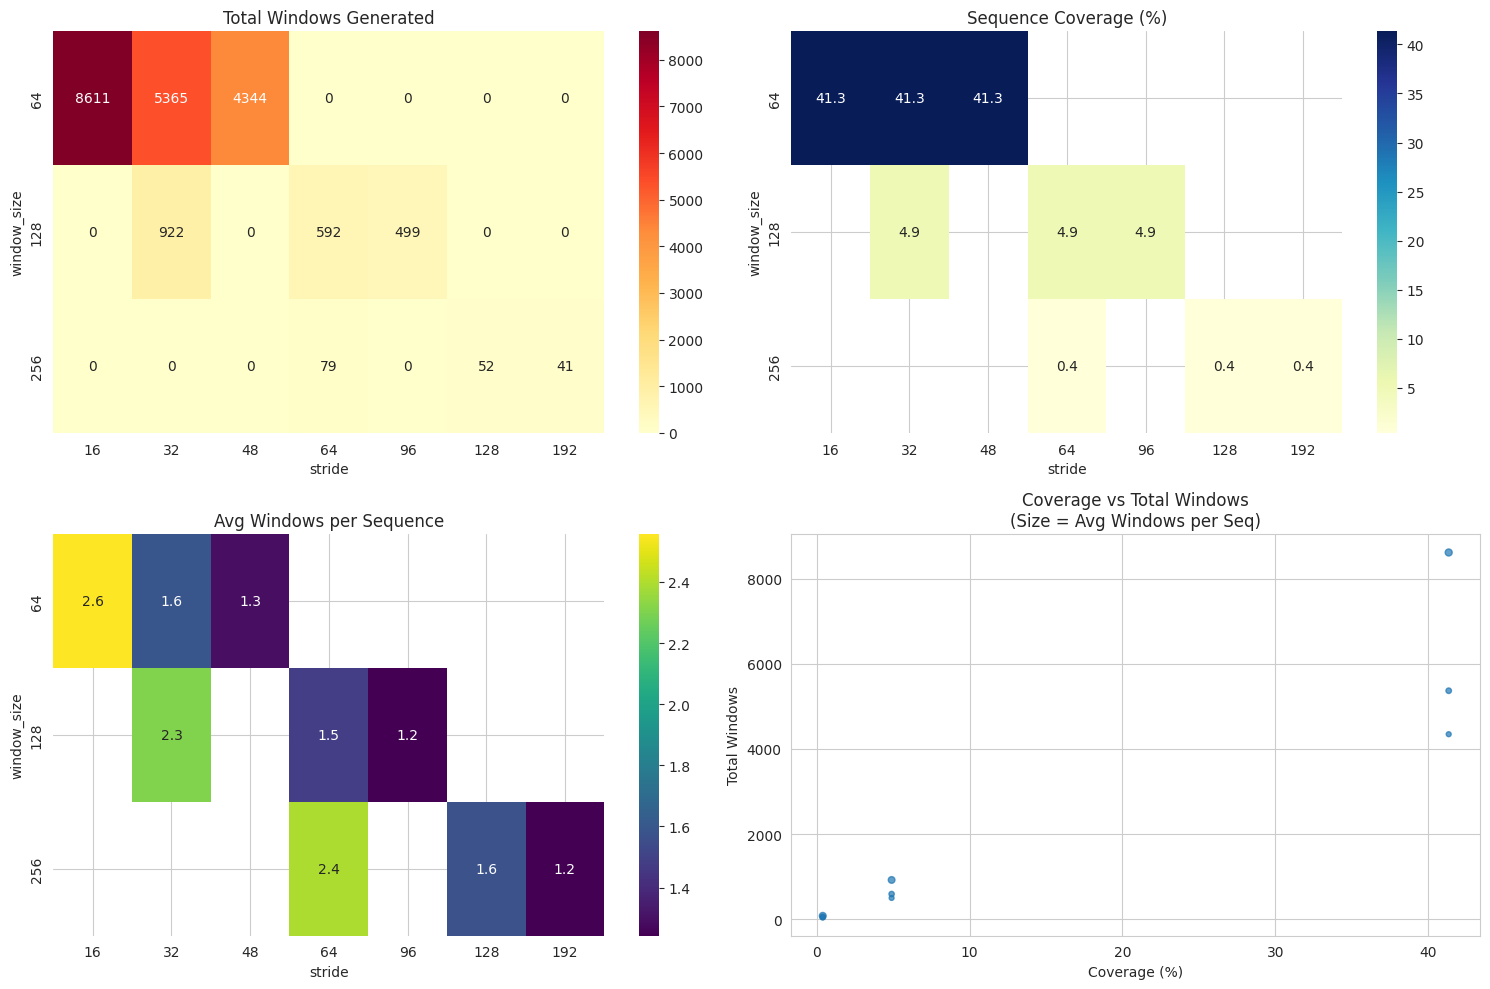

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 総ウィンドウ数（整数に補正）
pivot_windows = sim_df.pivot(index='window_size', columns='stride', values='total_windows')
sns.heatmap(pivot_windows.fillna(0).astype(int), annot=True, fmt='d', cmap='YlOrRd', ax=axes[0,0])
axes[0,0].set_title('Total Windows Generated')

# カバレッジ
pivot_coverage = sim_df.pivot(index='window_size', columns='stride', values='coverage_pct')
sns.heatmap(pivot_coverage, annot=True, fmt='.1f', cmap='YlGnBu', ax=axes[0,1])
axes[0,1].set_title('Sequence Coverage (%)')

# 平均ウィンドウ数/シーケンス
pivot_avg = sim_df.pivot(index='window_size', columns='stride', values='avg_windows_per_seq')
sns.heatmap(pivot_avg, annot=True, fmt='.1f', cmap='viridis', ax=axes[1,0])
axes[1,0].set_title('Avg Windows per Sequence')

# 推奨設定の散布図
axes[1,1].scatter(sim_df['coverage_pct'], sim_df['total_windows'], 
                  s=sim_df['avg_windows_per_seq']*10, alpha=0.7)
axes[1,1].set_xlabel('Coverage (%)')
axes[1,1].set_ylabel('Total Windows')
axes[1,1].set_title('Coverage vs Total Windows\n(Size = Avg Windows per Seq)')

plt.tight_layout()
plt.show()


## 5. FFT/周波数解析


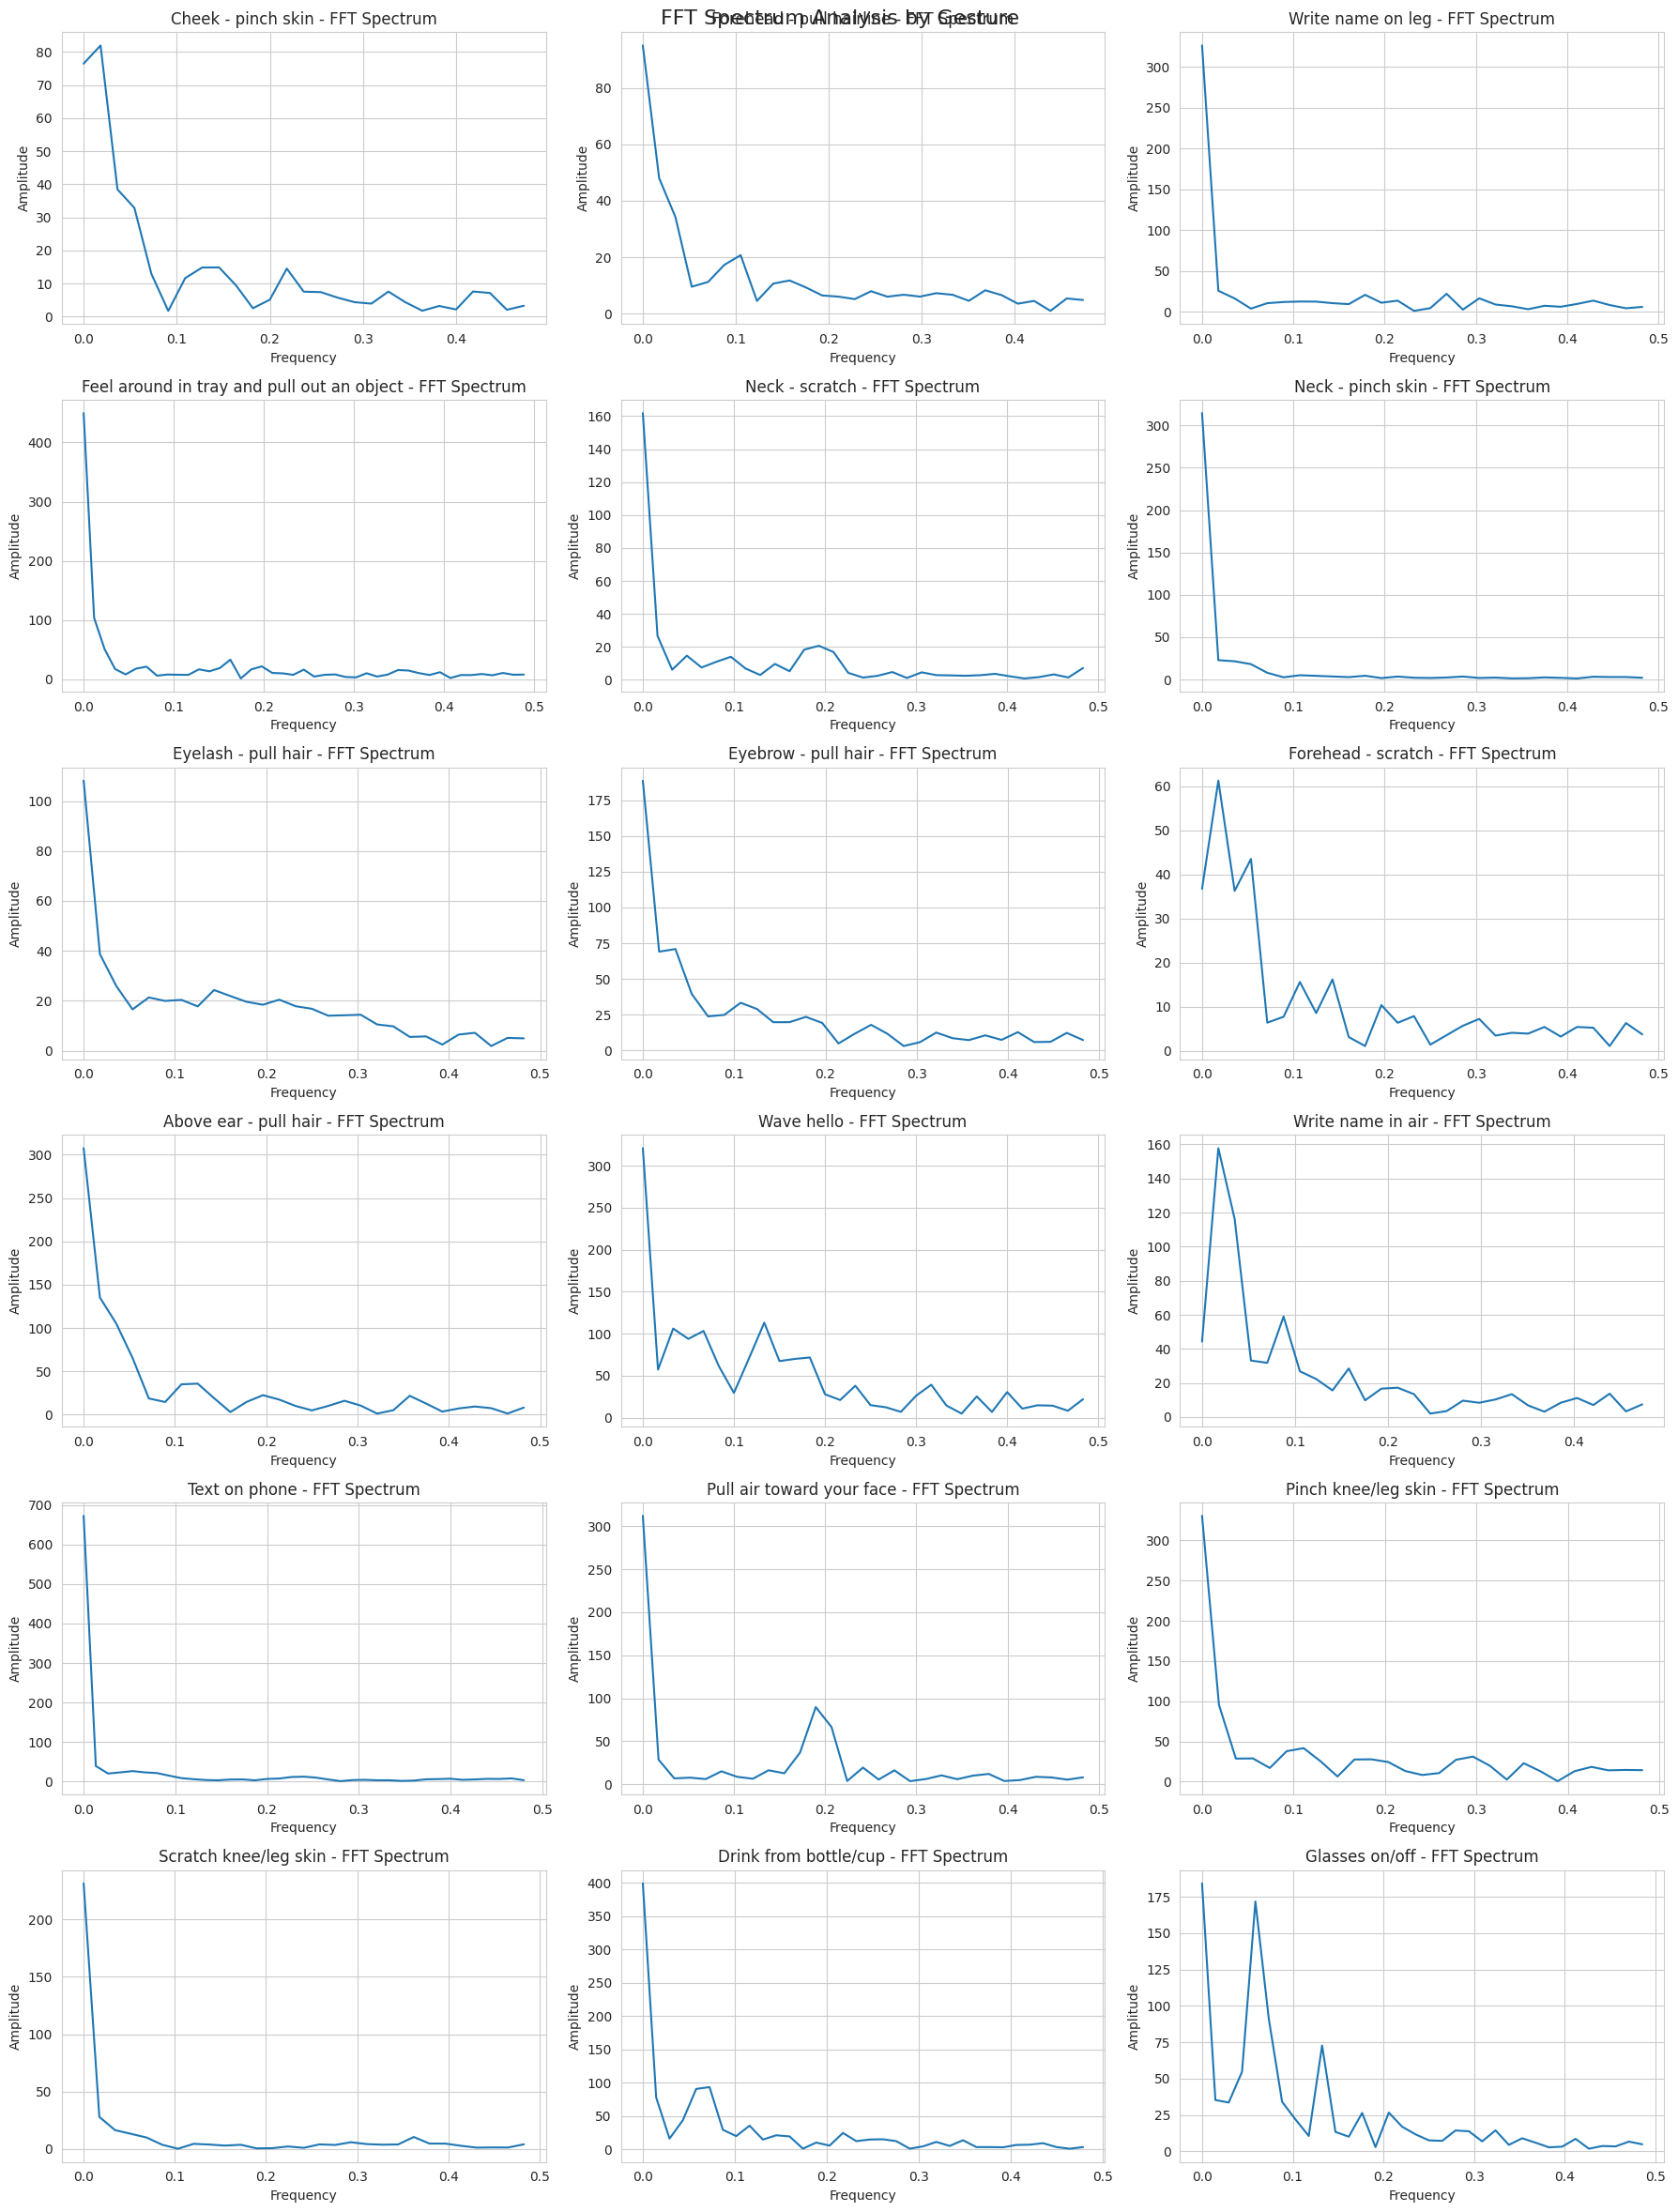

In [47]:
def analyze_frequency_domain(series, sampling_rate=1.0):
    """周波数領域解析"""
    # FFT計算
    fft_vals = fft(series)
    freqs = fftfreq(len(series), 1/sampling_rate)
    
    # 正の周波数のみ
    positive_freqs = freqs[:len(freqs)//2]
    positive_fft = np.abs(fft_vals[:len(fft_vals)//2])
    
    return positive_freqs, positive_fft

# 各ジェスチャーのFFT解析
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4*n_rows))
if n_rows == 1:
    axes = [axes] if n_cols == 1 else axes
else:
    axes = axes.flatten()

for i, (gesture, seq_id) in enumerate(sample_sequences):
    seq_data = train_df[train_df['sequence_id'] == seq_id]
    
    # 最初の加速度センサーでFFT解析
    if acc_cols[0] in seq_data.columns:
        freqs, fft_vals = analyze_frequency_domain(seq_data[acc_cols[0]])
        
        axes[i].plot(freqs, fft_vals)
        axes[i].set_title(f'{gesture} - FFT Spectrum')
        axes[i].set_xlabel('Frequency')
        axes[i].set_ylabel('Amplitude')
        axes[i].grid(True)

# 余った軸を非表示
for i in range(len(sample_sequences), len(axes)):
    axes[i].set_visible(False)

plt.suptitle('FFT Spectrum Analysis by Gesture', fontsize=16)
plt.tight_layout()
plt.show()


In [48]:
def simulate_windowing(sequence_length, window_size, stride):
    """ウィンドウ分割のシミュレーション"""
    if sequence_length < window_size:
        return 0
    
    num_windows = (sequence_length - window_size) // stride + 1
    return num_windows

# 異なるウィンドウサイズとストライドでのシミュレーション
window_configs = [
    (64, 16), (64, 32), (64, 48),
    (128, 32), (128, 64), (128, 96),
    (256, 64), (256, 128), (256, 192)
]

simulation_results = []

for window_size, stride in window_configs:
    total_windows = 0
    valid_sequences = 0
    
    for seq_len in sequence_lengths:
        num_windows = simulate_windowing(seq_len, window_size, stride)
        if num_windows > 0:
            total_windows += num_windows
            valid_sequences += 1
    
    coverage = valid_sequences / len(sequence_lengths) * 100
    avg_windows_per_seq = total_windows / valid_sequences if valid_sequences > 0 else 0
    
    simulation_results.append({
        'window_size': window_size,
        'stride': stride,
        'total_windows': total_windows,
        'valid_sequences': valid_sequences,
        'coverage_pct': coverage,
        'avg_windows_per_seq': avg_windows_per_seq
    })

sim_df = pd.DataFrame(simulation_results)
print("ウィンドウ分割シミュレーション結果:")
print(sim_df.round(2))


ウィンドウ分割シミュレーション結果:
   window_size  stride  total_windows  valid_sequences  coverage_pct  \
0           64      16           8611             3369         41.33   
1           64      32           5365             3369         41.33   
2           64      48           4344             3369         41.33   
3          128      32            922              400          4.91   
4          128      64            592              400          4.91   
5          128      96            499              400          4.91   
6          256      64             79               33          0.40   
7          256     128             52               33          0.40   
8          256     192             41               33          0.40   

   avg_windows_per_seq  
0                 2.56  
1                 1.59  
2                 1.29  
3                 2.31  
4                 1.48  
5                 1.25  
6                 2.39  
7                 1.58  
8                 1.24  


## 7. 推奨設定とまとめ


In [49]:
print("=== LSTM モデル開発のための推奨設定 ===")
print()

# 最適なウィンドウ設定を提案
best_config = sim_df.loc[sim_df['coverage_pct'] >= 90].nlargest(1, 'total_windows')
if not best_config.empty:
    print(f"推奨ウィンドウ設定:")
    print(f"  - Window Size: {best_config.iloc[0]['window_size']}")
    print(f"  - Stride: {best_config.iloc[0]['stride']}")
    print(f"  - Coverage: {best_config.iloc[0]['coverage_pct']:.1f}%")
    print(f"  - Total Windows: {best_config.iloc[0]['total_windows']:,}")
    print()

print("主要な発見:")
print(f"1. シーケンス長の範囲: {sequence_lengths.min()} - {sequence_lengths.max()}")
print(f"2. シーケンス長中央値: {sequence_lengths.median():.0f}")
print(f"3. センサー列数: {len(sensor_cols)}")
print(f"4. ジェスチャー数: {train_df['gesture'].nunique()}")
print()

print("LSTM モデリングの考慮点:")
print("- 時系列パターンがジェスチャーごとに異なる特徴を持つ")
print("- センサー間の相関が存在し、マルチモーダル学習が有効")
print("- 周波数領域特徴も識別に寄与する可能性")
print("- ウィンドウ分割により十分な学習データが確保可能")
print()

print("次のステップ:")
print("1. 推奨設定でウィンドウ分割を実装")
print("2. 時系列特徴量とFFT特徴量の統合")
print("3. LSTM アーキテクチャの設計")
print("4. 学習・検証パイプラインの構築")


=== LSTM モデル開発のための推奨設定 ===

主要な発見:
1. シーケンス長の範囲: 29 - 700
2. シーケンス長中央値: 59
3. センサー列数: 332
4. ジェスチャー数: 18

LSTM モデリングの考慮点:
- 時系列パターンがジェスチャーごとに異なる特徴を持つ
- センサー間の相関が存在し、マルチモーダル学習が有効
- 周波数領域特徴も識別に寄与する可能性
- ウィンドウ分割により十分な学習データが確保可能

次のステップ:
1. 推奨設定でウィンドウ分割を実装
2. 時系列特徴量とFFT特徴量の統合
3. LSTM アーキテクチャの設計
4. 学習・検証パイプラインの構築
